In [80]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from plots import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Mixture Models and the EM algorithm

## Mixture models
An alternative approach to graphical models is to assume that the observed variables are correlated because they arise from a hidden common 'cause'. Model with hidden variables are also known as **latent variable models** or **LVM**s. 

The simplest form of LVM is when $z_i\in\{1,\ldots,K\}$, representing a discrete latent state. We will use a discrete prior for this, $p(z_i) = \mathrm{Cat}(\boldsymbol{\pi})$. For the likelihood, we use $p(\mathbf{x}_i|z_i=k)=p_k(\mathbf{x}_i)$, where $p_k$ is the $k$'th **base distribution** for the observations; this can be any type. The overall model is known as a **mixture model**, since we are mixing together $K$ base distributions as follows:

$$
p(\mathbf{x}_i|\boldsymbol{\theta}) = \sum_{k=1}^K\pi_kp_k(\mathbf{x}_i|\boldsymbol{\theta})
$$

This is a **convex combination** of the $p_k$'s, since we are taking a weighted sum, where the **mixing weights** $\pi_k$ satisfy $0\le\pi_k\le 1$ and $\sum_{k=1}^K\pi_k = 1$.

### Mixture of Gaussians

The most widely used mixture model is the **mixture of Gaussians** (MOG), also called a **Gaussian mixture model** or **GMM**. In this model, each base distribution in the mixture is a multivariate Gaussian with mean $\boldsymbol{\mu}_k$ and covariance matrix $\boldsymbol{\Sigma}_k$. Thus the model has the form

$$
p(\mathbf{x}_i|\boldsymbol{\theta}) = \sum_{k=1}^K\pi_k\mathcal{N}(\mathbf{x}_i|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)
$$

Given a sufficiently large number of mixture components, a GMM can be used to approximate any density defined on $\mathbb{R}^D$.

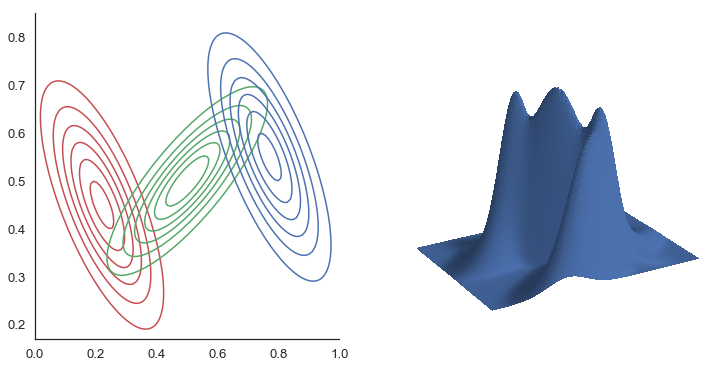

In [81]:
plot_gaussian_mixture()

### Mixture of multinoullis
We can use mixture models to define density models on many kinds of data. For example, suppose our data consist of $D$-dimensional bit vectors. In this case, an appropriate class conditional density is a product of Bernoullis:

$$
p(\mathbf{x}_i|z_i=k, \boldsymbol{\theta}) = \prod_{j=1}^D\mathrm{Ber}(x_{ij}|\mu_{jk}) = \prod_{j=1}^D\mu_{jk}^{x_{ij}}(1-\mu_{jk})^{1-x_{ij}}
$$

where $\mu_{jk}$ is the probability that bit $j$ turns on in cluster $k$. 

The latent variables do not have to have any meaning, we might simply introduce latent variables to make the model more powerful. 

### Using mixture models for clustering

There are two main applications of mixture models. The first is to use them as a **black-box** density model, $p(\mathbf{x}_i$. This can be useful for a variety of tasks, such as data compression, outlier detection, and creating generative classifiers, where we model each class conditional density $p(\mathbf{x}|y=c)$ by a mixture distribution.

The second and more common application of mixture models is to use them for clustering. The basic idea is simple. We first fit the mixture model, and then compute $p(z_i=k|\mathbf{x}_i, \boldsymbol{\theta})$, which represents the posterior probability that point $i$ belongs to cluster $k$. This known as the **responsibility** of cluster $k$ for point $i$, and can be computed using Bayes rule as follows:

$$
r_{ik}\triangleq p(z_i=k|\mathbf{x}_i, \boldsymbol{\theta}) = \frac{p(z_i=k|\boldsymbol{\theta})p(\mathbf{x}_i|z_i=k, \boldsymbol{\theta})}{\sum_{k'=1}^Kp(z_i=k'|\boldsymbol{\theta})p(\mathbf{x}_i|z_i=k',\boldsymbol{\theta})}
$$

This procedure is called **soft clustering** and is identical to the computations performed when using a generative classifier. The difference between the two models only arises at training time; in the mixture case, we never observe $z_i$, whereas with a generative classifier, we do observe $y_i$ (which plays the role of $z_i$).

We can represent the amount of uncertainty in the cluster assignment by using $1-\max_kr_{ik}$. Assuming this is small, it may be reasonable to compute a **hard clustering** using the MAP estimate, given by

$$
z_i^* = \mathrm{arg}\max_kr_{ik} = \mathrm{arg}\max_k\log p(\mathbf{x}_i|z_i=k, \boldsymbol{\theta}) + \log p(\mathbf{z}_i=k|\boldsymbol{\theta})
$$

### Mixture of experts
We can use mixture models to create discriminative models for classification and regression. We can model by allowing the mixing weights and the mixture densities to be input-dependent:

\begin{eqnarray}
p(y_i|\mathbf{x}_i, z_i=k, \boldsymbol{\theta}) & = & \mathcal{N}(y_i|\mathbf{x}_k^T\mathbf{x}_i, \sigma^2_k)\\
p(z_i|\mathbf{x}_i, \boldsymbol{\theta}) & = & \mathrm{Cat}(z_i|\mathcal{S}(\mathbf{V}^T\mathbf{x}_i))
\end{eqnarray}

This model is called a **mixture of experts** or MoE. The idea is that each submodel is considered to be an 'expert' in a certain region of input space. The function $p(z_i=k|\mathbf{x}_i, \boldsymbol{\theta})$ is called a **gating function** and decides which expert to use, depending on the input values. 

## The EM Algorithm

This is a simple iterative algorithm, often with closed form updates at each step. EM exploits the fact that if the data were fully observed, then the ML/MAP estimate would be easy to compute. In particular, EM is an iterative algorithm which alternates between inferring the missing values given the parameters (E step) and then optimizing the parameters given the 'filled in' data (M step). 

### Basic Idea
Let $\mathbf{x}_i$ be the visible or observed variables in case $i$, and let $\mathbf{z}_i$ be the hidden or missing variables. The goal is to maximize the log likelihood of the observed data:

$$
\mathcal{l}(\boldsymbol{\theta}) = \sum_{i=1}^N\log p(\mathbf{x}_i|\boldsymbol{\theta}) = \sum_{i=1}^N\log\left[\sum_{\mathbf{z}_i}p(\mathbf{x}_i, \mathbf{z}_i|\boldsymbol{\theta})\right]
$$
Unfortunately this is hard to optimize, since the log cannot be pushed inside the sum.

EM gets around this problem as follows. Define the **complete data log likelihood** to be 

$$
\mathcal{l}_c(\boldsymbol{\theta})\triangleq \sum_{i=1}^N\log p(\mathbf{x}_i,\mathbf{z}_i|\boldsymbol{\theta})
$$

This cannot be computed, since $\mathbf{z}_i$ is unknown. So let us define the **expected complete data log likelihood** as follows:

$$
Q(\boldsymbol{\theta},\boldsymbol{\theta}^{t-1})=\mathbb{E}\left[\mathcal{l}_c(\boldsymbol{\theta})|\mathcal{D},\boldsymbol{\theta}^{t-1}\right]
$$
where $t$ is the current iteration number. $Q$ is called the **auxiliary function**. The expectation is taken wrt to the old parameters. $\boldsymbol{\theta}^{t-1}$, and the observed data $\mathcal{D}$. The goal of the **E step** is to compute $Q(\boldsymbol{\theta}, \boldsymbol{\theta}^{t-1})$, or rather, the terms inside of it which the MLE depends on; these are known as the **expected sufficient statistics** or ESS. In the **M step**, we optimize the $Q$ function wrt $\boldsymbol{\theta}$:

$$
\boldsymbol{\theta}^t = \mathrm{arg}\max_{\boldsymbol{\theta}}Q(\boldsymbol{\theta}, \boldsymbol{\theta}^{t-1})
$$

To perform MAP estimation, we modify the M step as follows:

$$
\boldsymbol{\theta}^t = \mathrm{argmax}_{\boldsymbol{\theta}}Q(\boldsymbol{\theta}, \boldsymbol{\theta}^{t-1}) + \log p(\boldsymbol{\theta})
$$

The E step remains unchanged. Suitable prior will remove singularities.

### EM for Gaussian mixtures
Remember that the Gaussian mixture distribution can be written as a linear superposition of Gaussians in the form
$$
p(\mathbf{x}) = \sum_{k=1}^K\pi_k\mathcal{N}(\mathbf{x}|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k).
$$

The log likelihood function is given by

$$
\log p(\mathbf{x}|\boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \sum_{n=1}^N\log\left\{\sum_{k=1}^K\pi_k\mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)\right\}
$$.

Let's look at the conditions that must be satisfied at a maximum of the likelihood function. Setting the derivatives of $\log p$ with respect to the means $\boldsymbol{\mu}_k$ of the Gaussian components to zero, we obtain:

$$
0 = -\sum_{n=1}^N\frac{\pi_k\mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)}{\sum_{k=1}^K\pi_k\mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}\boldsymbol{\Sigma}_k(\mathbf{x}_n-\boldsymbol{\mu}_k)
$$

Multiplying by $\boldsymbol{\Sigma}_k{-1}$ (which we assume to be nonsingular) and rearranging we obtain

$$
\boldsymbol{\mu}_k = \frac{1}{N_k}\sum_{n=1}^N\gamma(z_{nk})\mathbf{x}_n
$$

where we have defined
$$
N_k = \sum_{n=1}^N\gamma(z_{nk})
$$

Note that 
$$
\gamma(z_{nk}) = \frac{\pi_k\mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)}{\sum_{k=1}^K\pi_k\mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}
$$
is the responsibility.

We can interpret $N_k$ as the effective number of points assigned to cluster $k$. We see that the mean $\boldsymbol{\mu}_k$ for the $k$th Gaussian component is obtained by taking a weighted mean of all the points in the data set, in which the weighting factor for data point $\mathbf{x}_n$ is given by the posterior probability $\gamma(z_{nk}$ that component $k$ was responsible for generating $\mathbf{x}_n$.

If we set the derivative of $\log p(\mathbf{x}|\boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Sigma})$ with respect to $\boldsymbol{\Sigma}_k$ to zero, and follow a similar line of reasoning, making use of the result for the maximum likelihood solution for the covariance matrix of a single Gaussian, we obtain

$$
\boldsymbol{\Sigma}_k = \frac{1}{N_k}\sum_{n=1}^N\gamma(z_{nk})(\mathbf{x}_n-\boldsymbol{\mu}_k)(\mathbf{x}_n-\boldsymbol{\mu}_k)^T
$$
which has the same form as the corresponding result for a single Gaussian fitted to the dataset, but again with each data point weighted by the corresponding posterior probability and with the denominator given by the effective number of points associated with the corresponding component.

### Algorithm
> Given a Gaussian mixture model, the goal is to maximize the likelihood function with respect to the parameters (comprising the means and covariances of the components and the mixing coefficients).
1. Initialize the means $\boldsymbol{\mu}_k$, covariances $\boldsymbol{\Sigma}_k$ and mixing coefficients $\pi_k$, and evaluate the initial value of the log likelihood.
2. **E step**. Evaluate the responsibilities using the current parameter values. $$
        \gamma(z_{nk}) = \frac{\pi_k\mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)}{\sum_{k=1}^K\pi_k\mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}$$
3. **M step**. Re-estimate the parameters using the current responsibilities
    \begin{eqnarray}
    \boldsymbol{\mu}_k^{\mathrm{new}} & = & \frac{1}{N_k}\sum_{n=1}^N\gamma(z_{nk})\mathbf{x}_n \\
    \boldsymbol{\Sigma}_k^{\mathrm{new}} & = & \frac{1}{N_k}\sum_{n=1}^N\gamma(z_{nk})(\mathbf{x}_n-\boldsymbol{\mu}_k^{\mathrm{new}})(\mathbf{x}_n-\boldsymbol{\mu}_k^{\mathrm{new}})^T\\
    \pi_k^{\mathrm{new}} & = & \frac{N_k}{N}
    \end{eqnarray}
where $$N_k = \sum_{n=1}^N\gamma(z_{nk}).$$
4. Evaluate the log likelihood
$$
\log p(\mathbf{x}|\boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \sum_{n=1}^N\log\left\{\sum_{k=1}^K\pi_k\mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)\right\}
$$
and check for convergence of either the parameters or the log likelihood. If the convergence criterion is not satisfied then return to step 2.
        